# Project HARDy Initial Concept:

## Producing Data-Rich images from Multi-data plots, instead of Human-readable Whitespace

### NOTE: HARD-CODED IMPORT IN CELL #1 (used after cell 15) - Please point to any of our Model-generated impedance data csvs in that location (sample should be in the examples/folder with this notebook)
### Created 2020-04-24

The core tenant of this project can be described by the difference between how Humans and Machine-Learning programs process images. We recognize patterns best when we have a fundemental understanding of what the X and Y axes mean on a plot, and when the data consists of lines and patterns on an otherwise white background. However, a CNN has no understanding of axes labels or meanings, and simply views the XY axes as relative positions to scan over. 

If X and Y are therefore arbitrary, confining ourselves to learning on a White-Background image leads to incredibly Data-Poor images in a computers' sense. First of all, White is read as Maximum value rather than zero value (how humans percieve it on a plot), so it can easily overwhelm the important data. Similarly, in a simple one-line image, almost every single pixel contains totally arbitrary data! 

What if, instead, we took our data set and made EVERY POINT in the image tell a story about the dataset? If every point has the potential to contain useful information, we hypothesize that the CNN will have a MUCH better chance of finding and "learning" the features which are most important to the task! 

In [2]:
testfile = "200308-0041_sim_two.csv"

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

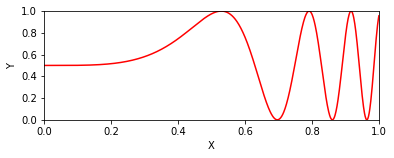

In [11]:
# Start by definining an X,Y... 
#ANY X,Y, but we'll start out making them both from 0 to 1, 
# because we'll have to Normalize AT LEAST the RGB data so PROBABLY normalize it all?
X_array = np.linspace(0,1,1001)
Y_array = 0.5 + 0.5*np.sin(20*X_array**4)

def quickplot(X,Y,fig=False,ax=False,color='k'):
    if not ax:
        fig, ax = plt.subplots(figsize=[6,2])
    ax.plot(X,Y,c=color)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    return fig, ax

fig,ax = quickplot(X_array,Y_array,color='r')

Text(0.5, 1.0, 'Transofrmations of X and Y')

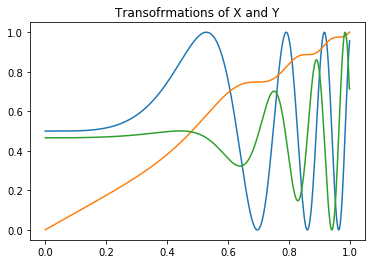

In [12]:
#I hate that at 4AM I can't find the most obviusly useful int Y dx function.
# SO goodamnit I'm making my own.

def david_integral(Y,X):  # To compute integral of Y dx
    if len(Y) != len(X):
        raise AssertionError("You f'd up")
    y_dx = Y*0
    z=0
    for i,y in enumerate(Y[:-1]):
        dx = X[i+1]-X[i]
        y_dx[i] = z + y
        z += y
    y_dx[-1]=z  # Fix end calculation
    return y_dx


def david_derrives(Y,X):  # To compute dy/dx (Smallest dx! noisewarning)
    if len(Y) != len(X):
        raise AssertionError("You f'd up")
    dydx = Y*0
    z=0
    for i,y in enumerate(Y[:-1]):
        dx = X[i+1]-X[i]
        dy = Y[i+1]-y
        dydx[i] = dy/dx
    dydx[-1]=dydx[-2] # Fix end calculation
    return dydx

def norm_01(X): # normalize an array between 0(MIN) and 1(MAX)
    if min(X)<0:
        X+=abs(min(X))
    if max(X)>1:
        X=X/max(X)
    return X

def norm_pm1(X): # normalize an array between 0(-Max(Abs())) and 1(+Max(Abs()))
    Xrange = max(abs(X)) # This will be (plus or minus) the 0 to 1 result
    
    X += XRange #Shift up by XRange so -Xrange is now zero
    X = X / (2*XRange) # +Xrange is now 2*Xrange, so compress that down to be 1.
    return X

y_dx = david_integral(Y_array,X_array) # Test
dydx = david_derrives(Y_array,X_array)

y_dx = norm_01(y_dx)                    # Normalize
dydx = norm_01(dydx)
fig,ax=plt.subplots()                  # Plot  
ax.plot(X_array,Y_array)
ax.plot(X_array,y_dx)
ax.plot(X_array,dydx)
ax.set_title("Transofrmations of X and Y")


Text(0, 0.5, 'ARBITRARY, or Y')

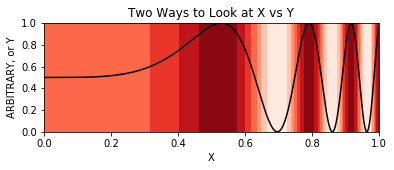

In [13]:
## Now, Make that a 1D plot, using Meshgrid and using the Y data as a Color! 
#IT WORKS! Now Functionalize it!
def colorplot(X, Y, fig=False,ax=False,cmap="Reds"):
    mesh1D_X, arb_x= np.meshgrid(X,np.linspace(0,1,101))
    mesh1D_Y, arb_y = np.meshgrid(Y,np.linspace(0,1,101))
    # Now we have two equally sized 2d surfaces, with "arbitrary" 0-1 Y-values but their different values in Y.??? 
    # Somehow apply the Y values to the Colorspace in a plot function... Have to quickly look that up...
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.contourf.html
    if ax is False:
        fig,ax = plt.subplots(figsize=[6,2])
    cs = plt.contourf(mesh1D_X, arb_x,mesh1D_Y,cmap=cmap)
    return fig,ax

fig,ax = plt.subplots(figsize=[6,2])
quickplot(X_array,Y_array,fig=fig,ax=ax)
#ax.contourf(mesh1D_X, arb_x,mesh1D_Y,cmap='Reds')
colorplot(X_array,Y_array,fig=fig,ax=ax,cmap="Reds")
ax.set_title("Two Ways to Look at X vs Y")
ax.set_ylabel("ARBITRARY, or Y")

# It's at this point I give up on colormaps since they don't combine *(and are cheating)*....
## Instead, Learn how to show as actual RGB Images (one color per Transform).
Link: <https://stackoverflow.com/questions/8145791/how-to-assign-rgb-color-values-to-grid-mesh-with-matplotlib>


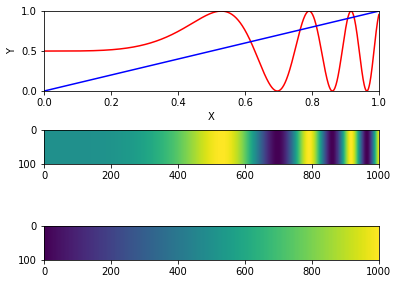

In [14]:
mesh1D_X, arb_x= np.meshgrid(X_array,np.linspace(0,1,101))
mesh1D_Y, arb_y = np.meshgrid(Y_array,np.linspace(0,1,101))

fig,ax=plt.subplots(3,1,figsize=[6,5])

quickplot(X_array,Y_array,fig=fig,ax=ax[0],color='r')
quickplot(X_array,X_array,fig=fig,ax=ax[0],color='b')

ax[1].imshow(mesh1D_Y)
ax[2].imshow(mesh1D_X)

### Ok that works, but how to make sure it's an RGB image?
Use ND ARRAY from Nupmy, which is how matplotlib Imshow() wants it's RGB Data to be encoded!
LINK: <https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.imshow.html>

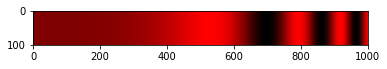

In [15]:

Y_Red=[mesh1D_Y,mesh1D_Y*0,mesh1D_Y*0]

type(mesh1D_Y)
mesh1D_Y.shape
Y_Red = np.ndarray(shape=(mesh1D_Y.shape[0],
                          mesh1D_Y.shape[1],
                          3))
Y_Red[:,:,0] = mesh1D_Y
plt.imshow(Y_Red)

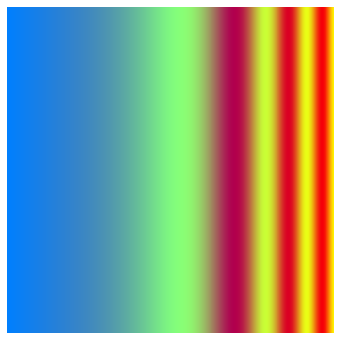

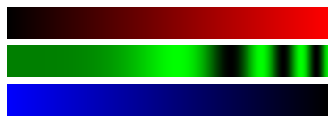

In [16]:

def combine_1D_colors(r_array,g_array=[0,0],b_array=[0,0], plot=True):
    r=len(r_array)
    g=len(g_array)
    b=len(b_array)
    
    if r != g:
        g_array = r_array * 0
        print ("Green Array Failed? (Or none given)")
    if r != b:
        b_array = r_array * 0
        print ("Blue  Array Failed? (Or none given)")
    
    # Normalize Data from 0 to 1 (aka RGB readable)
    r_array = norm_01(r_array)
    g_array = norm_01(g_array)
    b_array = norm_01(b_array)
    
    
    # Two types of Meshes: One 10 larger than the other
    # (Smaller used for Individual 1D arrays, Larger for combined)
    # FOR LATER--> MAKE BIG MATRIX A SQUARE! EASY TO COMBINE
    arb_big = np.linspace(0,1,r)
    arb_small = np.linspace(0,1,int(r/10))
    x_later = np.linspace(0,r,r)
                          
    r_small,a = np.meshgrid(r_array,arb_small)            
    g_small,a = np.meshgrid(g_array,arb_small)           
    b_small,a = np.meshgrid(b_array,arb_small) 
    
    r_big,a = np.meshgrid(r_array,arb_big)            
    g_big,a = np.meshgrid(g_array,arb_big)          
    b_big,a = np.meshgrid(b_array,arb_big)  
    
    
    big_plot = np.ndarray(shape=(r,r,3))
    r_plot = np.ndarray(shape=(int(r/10),r,3))
    g_plot = np.ndarray(shape=(int(r/10),r,3))
    b_plot = np.ndarray(shape=(int(r/10),r,3))
    
    big_plot[:,:,0] = r_big
    big_plot[:,:,1] = g_big
    big_plot[:,:,2] = b_big
    
    r_plot[:,:,0] = r_small
    g_plot[:,:,1] = g_small
    b_plot[:,:,2] = b_small
    
    r_plot[:,:,1] = r_plot[:,:,2]=r_small*0
    g_plot[:,:,0] = g_plot[:,:,2]=g_small*0
    b_plot[:,:,0] = b_plot[:,:,1]=b_small*0
    
    if plot:
        big,bax = plt.subplots(1,1,figsize=[6,6])
        fig,ax = plt.subplots(3,1,figsize=[6,2])

        bax.imshow(big_plot)
        ax[0].imshow(r_plot)
        ax[1].imshow(g_plot)
        ax[2].imshow(b_plot)

        #ax[0].plot(x_later,r_array)


        bax.axis('off')
        for i in [0,1,2]:
            ax[i].axis('off')
    
    return big_plot

test_array_1= combine_1D_colors(X_array,Y_array,-X_array)

Non-Normalized MinMax:
[0.5, 579.0304909543303]
[-33.39169824874874, 38.271191650027816]


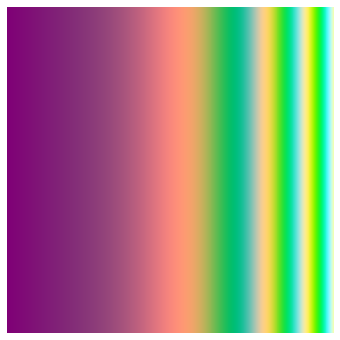

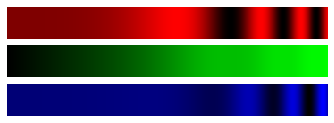

In [17]:
# Test if that Normalization worked, 
#      and Also, try a transform on the data... How about Integration!
#      (I had to make my own function... See above...)

y_dx = david_integral(Y_array,X_array) # Test
dydx = david_derrives(Y_array,X_array)
print("Non-Normalized MinMax:")
print([min(y_dx), max(y_dx)])
print([min(dydx), max(dydx)])

test_array_2 = combine_1D_colors(Y_array, y_dx, dydx)

Text(0.5, 1.0, 'Combined by Average')

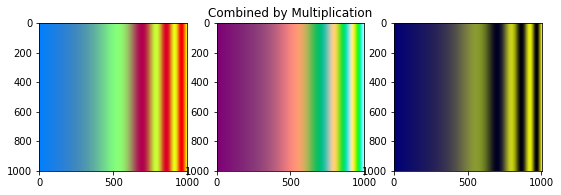

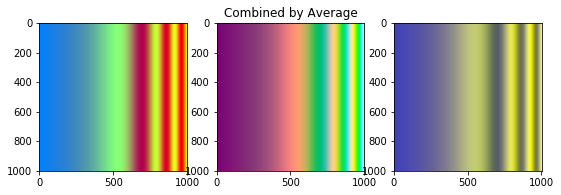

In [20]:
#Proof of concept: We're exporting the Images in a way that can be multiplied!
#                  (but only if same size... but size is arbitrary here!
#                  NOTE: Multiplying 0-1 will only ever get DARKER...
#                  Idea?? Double each before multiply, so >50% gets brighter?
#                  IS that what we call "Increasing the Contrast???" OMG
test_array_3 = test_array_1*test_array_2
fig,ax=plt.subplots(1,3,figsize=[9,3])
ax[0].imshow(test_array_1)
ax[1].imshow(test_array_2)
ax[2].imshow(test_array_3)
ax[1].set_title("Combined by Multiplication")


test_array_3 = (test_array_1+test_array_2)/2
fig,ax=plt.subplots(1,3,figsize=[9,3])
ax[0].imshow(test_array_1)
ax[1].imshow(test_array_2)
ax[2].imshow(test_array_3)
ax[1].set_title("Combined by Average")

## OK, so now we can put any 3 functions on the same plot as colors - it's still essentially 1D.

### Now, combine two 1D plots into a 2-D plot, so you'll then have 6 Functions on the same plot. 
### (Second Plot will be converted to Vertical information)


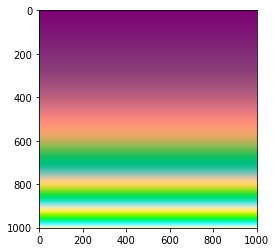

In [21]:
T_1 = np.ndarray(shape=test_array_2.shape)
for i in (0,1,2):
    T_1[:,:,i] = test_array_2[:,:,i].transpose()
plt.imshow(T_1)

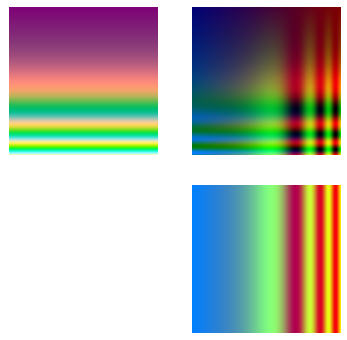

In [22]:
def combine_1D_2D(img_x,img_y,plot=True):
    """
    Takes in two images of shape=(ARBITRARY, Data-axis, 3)
    EDIT: FOR NOW, ASSUME SQUARE - Makes Math Easy!
    """
    img_y_flip = np.ndarray(shape=img_y.shape)
    for i in (0,1,2):
        img_y_flip[:,:,i] = img_y[:,:,i].transpose()
    
    combo_img = img_x *img_y_flip
    
    if plot:
        fig,ax = plt.subplots(2,2,figsize=[6,6])
        ax[0][0].imshow(img_y_flip)
        ax[0][1].imshow(combo_img)
        ax[1][1].imshow(img_x)

        ax[0][0].axis('off')
        ax[0][1].axis('off')
        ax[1][0].axis('off')
        ax[1][1].axis('off')
    
    return combo_img

test_2d_1 = combine_1D_2D(test_array_1,test_array_2)


## Ok that's cool (and looks like the old Slack Crosshatch?)
*(the one from before the d!%#Pinwheel)*

# So, now try loading up one of our impedance files?
Hardcode filename for now, and discuss the data before we explore...


Skipped 6 Rows


,Unnamed: 0,freq [Hz],angular_freq [1/s],Re_Z [ohm],Im_Z [ohm],|Z| [ohm],phase_angle [rad]
0,0,1.000000e+08,6.283185e+08,150.000780,-0.003251,150.000780,-0.000022
1,1,7.162629e+07,4.500413e+08,150.001036,-0.004317,150.001036,-0.000029
2,2,5.130326e+07,3.223479e+08,150.001375,-0.005733,150.001375,-0.000038
3,3,3.674662e+07,2.308858e+08,150.001827,-0.007614,150.001827,-0.000051
4,4,2.632024e+07,1.653749e+08,150.002426,-0.010112,150.002426,-0.000067


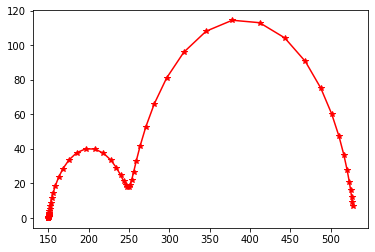

In [23]:
# Moved the Hard-Coded File to TOP of notebook!

# testfile = "C:\\Users\\conta\\Documents\\Py\\DIRECT\\200308-0001_sim_one.csv"
i=0
while i<100:
    try:
        fdata=pd.read_csv(testfile,skiprows=i)
        ax=plt.plot(fdata['Re_Z [ohm]'],-fdata['Im_Z [ohm]'],'-*r')
        break
    except:
        i+=1
print("Skipped {} Rows".format(i))
fdata.head()


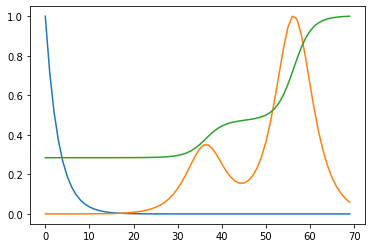

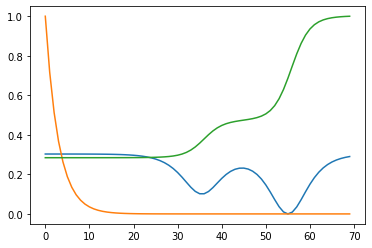

In [24]:
fig,ax=plt.subplots()
x=range(0,len(fdata['freq [Hz]']))
ax.plot(x,norm_01(fdata['freq [Hz]']))
ax.plot(x,norm_01(-fdata['Im_Z [ohm]']))
ax.plot(x,norm_01(fdata['Re_Z [ohm]']))

fig,ax=plt.subplots()
x=range(0,len(fdata['freq [Hz]']))
ax.plot(x,norm_01(fdata['phase_angle [rad]']))
ax.plot(x,norm_01(fdata['angular_freq [1/s]']))
ax.plot(x,norm_01(fdata['|Z| [ohm]']))


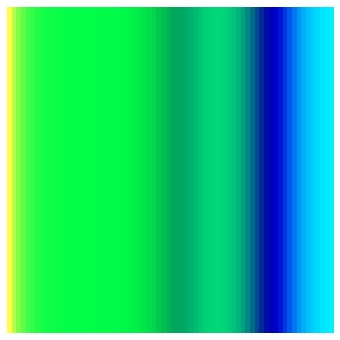

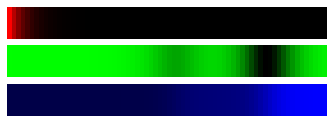

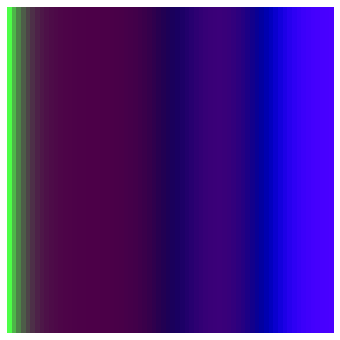

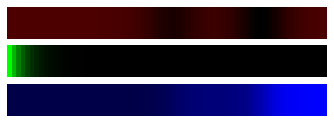

In [25]:
# First Try... 
#  R = Frequency
#  G = Imaginary Z
#  B = Real Z

"../eisy/eisy/eisy_file_mgmt.py"
EISy_plot_1 = combine_1D_colors(fdata['freq [Hz]'],
                                fdata['Im_Z [ohm]'],
                                fdata['Re_Z [ohm]'])

# Second Round of Data...
#  R = Phase Angle
#  G = Angular Freq
#  B = Total Z

EISy_plot_2= combine_1D_colors(fdata['phase_angle [rad]'],
                               fdata['angular_freq [1/s]'],
                               fdata['|Z| [ohm]'])




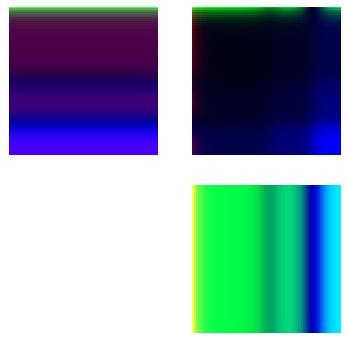

In [36]:
test_2d_1 = combine_1D_2D(EISy_plot_1,EISy_plot_2)

With 7 Keys into 6D Data...
There are 5040.0 Possible Plots...
    (but some will repeat)
This time, the RGB were:
X:	['angular_freq [1/s]', 'phase_angle [rad]', 'Re_Z [ohm]']
Y:	['freq [Hz]', 'Im_Z [ohm]', 'Unnamed: 0']



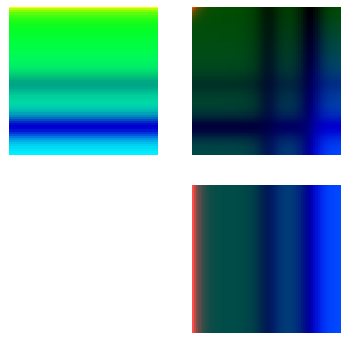

In [26]:
import random
def random_6D_plot(dataframe, plot=False):
    key_list = list(dataframe.keys())
    if plot:
        print("With "+str(len(key_list))+" Keys into 6D Data...\n" +
              "There are "+str(np.math.factorial(len(key_list))/np.math.factorial(len(key_list)-6))+
              " Possible Plots...\n    (but some will repeat)")    
    plot_keys = random.sample(key_list,6)
    if plot:
        print("This time, the RGB were:\n"+
              "X:\t"+str([plot_keys[0],plot_keys[1],plot_keys[2]])+"\n"+
              "Y:\t"+str([plot_keys[3],plot_keys[4],plot_keys[5]])+"\n")
    
    data_1 = combine_1D_colors(dataframe[plot_keys[0]],
                               dataframe[plot_keys[1]],
                               dataframe[plot_keys[2]],
                               plot=False)
    data_2 = combine_1D_colors(dataframe[plot_keys[3]],
                               dataframe[plot_keys[4]],
                               dataframe[plot_keys[5]],
                               plot=False)
    ThePlot = combine_1D_2D(data_1,data_2,plot=plot)

    return ThePlot, plot_keys

A=random_6D_plot(fdata,plot=True)
#Timeit notes: 47ms per loop with Plot=True, 1.9ms with Plot=False

#NOTE: at 1.9 ms and (in this testcase) 5040 possible plots:
#      complete set /could/ be run in 10 Seconds?!? (rather than using Random Sample which may/will repeat some)

1

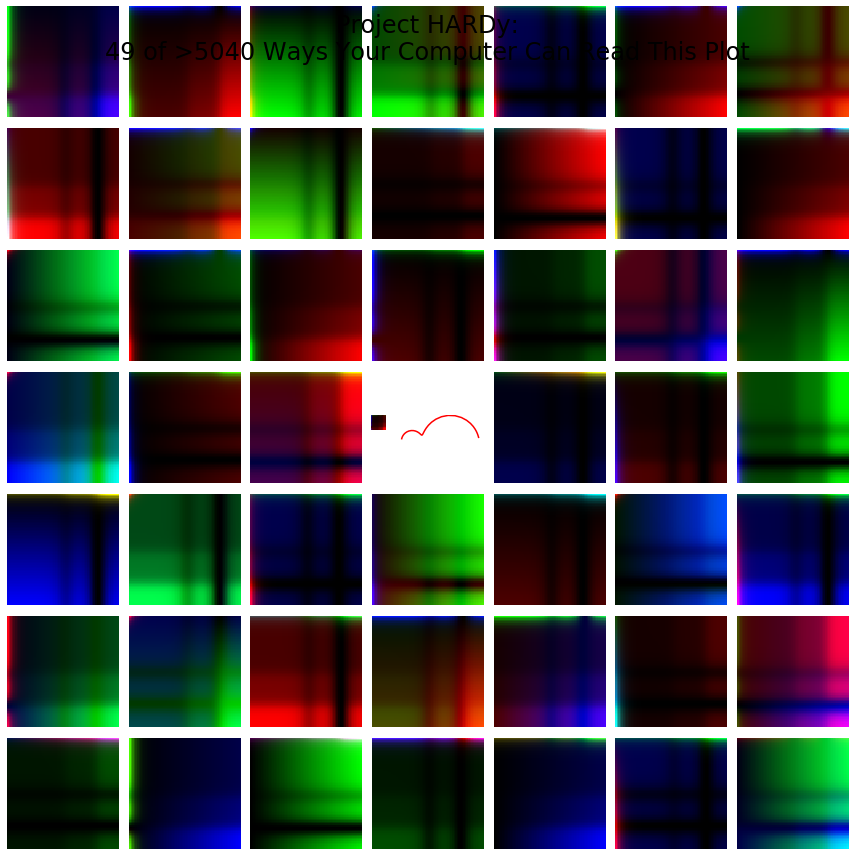

In [27]:
def random_plot_grid(dataframe,n=3,centerNyquist=False):
    """
    Generate an N-by-N grid of plots for the dataframe, to demonstrate the time required and randomness of the data.
    Note* Check that plot is unique (since we're using the RNG...).
          Question: do we count different orders as unique? for now, yes?
          
    """
    fig,ax=plt.subplots(n,n,figsize=[12,12])

    plotlist=[]
    keylist=[]
    n_plots = n**2
    wins=0
    esc=0
    for x in range(n):
        for y in range(n):
            plot, keys = random_6D_plot(dataframe,plot=False)
            while keys in keylist and esc<100:
                print('already there? redo!')
                esc+=1
                plot, keys=random_6D_plot(dataframe,plot=False)
            plotlist.append(plot)
            keylist.append(keys)
            wins+=1
            ax[x][y].imshow(plot)
            ax[x][y].axis('off')
    plt.tight_layout()        
    fig.suptitle((str(n**2)+" Different 6D-Plots For The Same Data"), fontsize=24)
        
    # Now, IF instructed to (and odd n)
    if centerNyquist and n%2:
        ax[int(n/2)][int(n/2)].plot(fdata['Re_Z [ohm]'],fdata['Im_Z [ohm]'],'-r')
        ax[int(n/2)][int(n/2)].axis('off')
        fig.suptitle("Project HARDy:\n{} of >{} Ways Your Computer Can Read This Plot".format(n**2,
                    np.math.factorial(n)), fontsize=24)
    
        

a= random_plot_grid(fdata,7, centerNyquist=True)

## Potential Next-Steps and DH Questions:
* _Data Transformation:_ This data is not at all transformed and is simply plotting directly from file (except normalized into the RGB 0-1 range)... We could add many additional axes to the datasets, although of course that drastically expands the # of potential plots...
* _Is it OK to multiply XY this way?:_ for example, the large black-zones where one axes (such as Frequency, with almost all data points ~=0) almost completely erases the axes it's paired with...
* _Editing Contrast / Multiplying non-darkening?)_ There are many ways other than multiplication to combine these datasets - they could be Added and then rescaled (AKA: Taking a sort of weighted Average), or simply averaging them)...

## Try It?: What if we take one or a few of these plots (since they nominally include ALL the data from a nyquist plot and more?), and generate them for our existing dataset and see if the CNN model can train on them???
